# Polynomial Fitting

Similarly to the linear fit and the transit model we can instead fit our data with a polynomial model. The difference from the linear fit tutorial is that in this case we'll generate a slightly different polynomial function  for each wavelength and see how well our model can recover the parameters.

In [1]:
from chromatic_fitting import *
from pymc3 import Normal, Uniform

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.0.4!

This program is running on:
Python v3.9.12 (main, Jun  1 2022, 06:34:44) 
[Clang 12.0.0 ]
numpy v1.22.1
chromatic v0.3.14
pymc3 v3.11.5
pymc3_ext v0.1.1
exoplanet v0.5.2


First we'll create a Rainbow object from chromatic and then add a wavelength-dependent polynomial model:

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

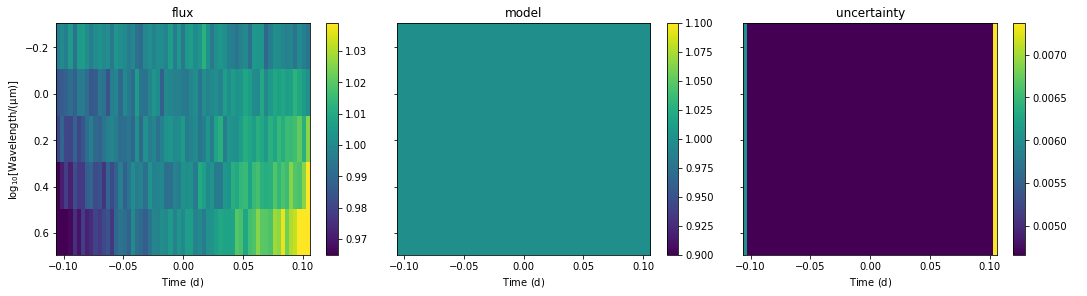

In [2]:
# create simulated rainbow
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=20)

# bin:
nw = 5
rb = r.bin(nwavelengths=int(r.nwave/nw), dt=5 * u.minute)

# create wavelength-dep linear + constant model:
a = 0.0
b = 0.05
c = 0.0
d = 5.0
x = rb.time.to_value("day")

true_a, true_b, true_c, true_d, poly = [],[],[],[],[]

for i in range(rb.nwave):
    true_a.append(a + 1)
    true_b.append(b*i)
    true_c.append(c*i)
    true_d.append(d*i)
    poly.append((d*i*(x**3)) + (c*i*(x**2)) + (b*i*x))
rb.fluxlike['flux'] = rb.flux + np.array(poly)

# plot our Rainbow to see how it looks
rb.imshow_quantities();

Let's plot our data in 2-D so we can see the polynomial shapes we've added:

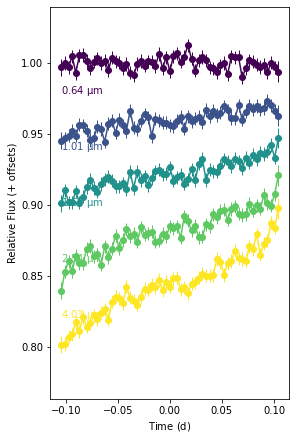

In [3]:
rb.plot_lightcurves();

## Create Polynomial Model

We set up the `PolynomialModel` similarly to the [linear model tutorial](https://catrionamurray.github.io/chromatic_fitting/tutorial_for_linear_fitting/), however, we need to provide the `degree` of the polynomial. By setting this argument we can fix some of our degrees to zero. For example if we have a linear model but we want a zero constant offset we could ignore the `p_0` parameter which would be fixed by default to 0. 

In [4]:
# set up polynomial model:
p = PolynomialModel(degree=3)

p.setup_parameters(
    p_0 = WavelikeFitted(Uniform,testval=0.01,upper=2,lower=-2),
    p_1 = WavelikeFitted(Uniform,testval=0.01,upper=1,lower=-1),
    p_2 = WavelikeFitted(Uniform,testval=0.01,upper=1,lower=-1),
    p_3 = WavelikeFitted(Uniform,testval=0.01,upper=25,lower=-5)
)

# print a summary of all params:
p.summarize_parameters()

polynomial_p_0 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=2, lower=-2, name='polynomial_p_0') for each wavelength 🧮>

polynomial_p_1 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=1, lower=-1, name='polynomial_p_1') for each wavelength 🧮>

polynomial_p_2 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=1, lower=-1, name='polynomial_p_2') for each wavelength 🧮>

polynomial_p_3 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=25, lower=-5, name='polynomial_p_3') for each wavelength 🧮>



In [5]:
# setup model the same way as for the transit model!:
p.attach_data(rb)
p.setup_lightcurves(store_models=True)
p.setup_likelihood()

Let's check our PyMC3 model and make sure that the parameters have been set up okay!

In [6]:
print(p._pymc3_model)

polynomial_p_0_interval__ ~ TransformedDistribution
polynomial_p_1_interval__ ~ TransformedDistribution
polynomial_p_2_interval__ ~ TransformedDistribution
polynomial_p_3_interval__ ~ TransformedDistribution
           polynomial_p_0 ~ Uniform
           polynomial_p_1 ~ Uniform
           polynomial_p_2 ~ Uniform
           polynomial_p_3 ~ Uniform
         polynomial_model ~ Deterministic
                     data ~ Normal


Looks good, now onto sampling our model...

## Sampling our Model

Now we can try to fit our model! Here we will first perform an optimization step (to give our sampling a good first guess) and then the actual NUTS sampling with a number of tuning and draw steps and chains that we define. We can also choose how many cores to assign to this sampling! Bear in mind that we have a decent number of parameters to fit (simultaneously) and so we want to make sure we have enough steps in the MCMC!

In [ ]:
# optimize for initial values!
opt = p.optimize(plot=False)

# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains.
p.sample(start=opt, tune=2000, draws=4000, chains=4, cores=4)

optimizing logp for variables: [polynomial_p_3, polynomial_p_2, polynomial_p_1, polynomial_p_0]


message: Optimization terminated successfully.
logp: -6759054.489775105 -> 1198.0407161025278
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [polynomial_p_3, polynomial_p_2, polynomial_p_1, polynomial_p_0]


Now we can look at our results:

In [ ]:
p.summarize(round_to=7, hdi_prob=0.68, fmt='wide')

r_hat parameters are close to 1, which is a good sign that our chains have converged!

In [ ]:
p.get_results(uncertainty=['hdi_16%','hdi_84%'])

In [ ]:
model = p.get_model()
model.keys()

## Plot Results

Remember that handy `plot_lightcurves()` function from earlier? Once we have generated a model it *should* now overplot those models on top of the data.

In [ ]:
p.plot_lightcurves()

We can also use the `chromatic` functions wrapped in `chromatic_fitting` that can let us look at the residuals:

In [ ]:
p.plot_with_model_and_residuals()

In [ ]:
p.imshow_with_models(vlimits_data=[0.96, 1.04])

## Compare Results to the True Values

We can also compare our fitted results to the true values we put in:

In [ ]:
results = p.get_results(uncertainty=['sd','sd'])
results

In [ ]:
print("\t\t\tTrue, \tFitted")
for w in range(p.data.nwave):
    for i, coeff in zip(range(p.degree+1),[true_a, true_b, true_c, true_d]):
        print(f"wavelength {w}, p_{i}:\t {round(coeff[w],2)}, \t",results.loc[f'w{w}'][f"{p.name}_p_{i}"],"+/-",results.loc[f'w{w}'][f"{p.name}_p_{i}_sd"])

Let's plot the data, the true regression line and our fit and see how they compare (If we used `store_model=True` at the `.setup_lightcurves()` stage then we could easily generate a 1-sigma region for the model using the errors stored in the summary table!):

In [ ]:
fig, ax = plt.subplots(p.data.nwave, figsize=(12,18))
p.plot_model(ax=ax)
plt.tight_layout();

# get 1-sigma region (only if store_models=True!!):
onesigma={}
for w in range(p.data.nwave):
    if f"w{w}" not in onesigma.keys():
        onesigma[f"w{w}"] = []
    for t in range(p.data.ntime):
        onesigma[f"w{w}"].append(p.summary["sd"][f"{p.name}_model[{w}, {t}]"])
        
        
for i in range(len(poly)):
    ax[i].fill_between(p.data.time.to_value("d"), np.array(model[f"w{i}"])-onesigma[f"w{i}"], np.array(model[f"w{i}"])+onesigma[f"w{i}"], label='1-sigma', alpha=0.3)
    ax[i].plot(p.data.time, poly[i] + 1, label="True polynomial")
    ax[i].legend()

This is a good example to see where the model does a good job of fitting, and where, when the noise is larger than the signal, it can overfit (wavelength 0).